In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

In [2]:
PATH_DATA = os.path.join("..", "data", "raw", "raw_data_finance.csv")

SPLIT_DATE = '2017-01-31'

In [3]:
df = pd.read_csv(PATH_DATA, sep=";", index_col="date").drop(columns="Unnamed: 0")

/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_72784/1118541769.py:1: DtypeWarning: Columns (6,8,16,17,26,33,34,66,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,252,253,255,257,259,261,263,265,267,269,270,271,272,273,274,275,276,277,278,279,280,284,285,286,290) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH_DATA, sep=";", index_col="date").drop(columns="Unnamed: 0")


In [4]:
df.head()

,symbol,year,quarter,week,acceptedDate,calendarYear,cik,costAndExpenses,costOfRevenue,depreciationAndAmortization,...,estimatedRevenueAvg,estimatedRevenueHigh,estimatedRevenueLow,estimatedSgaExpenseAvg,estimatedSgaExpenseHigh,estimatedSgaExpenseLow,numberAnalystEstimatedRevenue,numberAnalystsEstimatedEps,close,volume
date,,,,,,,,,,,,,,,,,,,,,
1995-01-31,ALMIL.PA,1995,1,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,ALMIL.PA,1995,3,13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,ALMIL.PA,1995,6,26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-30,ALMIL.PA,1995,9,39,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-31,ALMIL.PA,1996,1,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Standardize NaNs

In [5]:
df = df.replace("missing", np.NAN)

### Cast columns to the correct types

In [6]:
df = df.apply(pd.to_numeric, errors="ignore")

### Drop duplicates

In [7]:
df = df.drop_duplicates()

### Filter by date

In [8]:
df = df[df.index > SPLIT_DATE]

### Filter out symbols with the low market capitalisation

In [9]:
symbol_total_cap = df.groupby("symbol").marketCap.sum()
good_symbols = symbol_total_cap[symbol_total_cap != 0].index.tolist()
df = df[df.symbol.isin(good_symbols)]

### Filter out features, which can contain no values for specific symbol

In [10]:
all_columns = df.columns
bad_columns = set()

for symbol in good_symbols:
    bad_columns = bad_columns.union(all_columns[df[df.symbol == symbol].isna().all()])

In [11]:
good_columns = set(all_columns).difference(bad_columns)

In [12]:
good_columns

{'addTotalDebt',
 'assetTurnover',
 'bookValuePerShare',
 'capexPerShare',
 'cashPerShare',
 'close',
 'companyEquityMultiplier',
 'debtEquityRatio',
 'debtRatio',
 'debtToAssets',
 'debtToEquity',
 'earningsYield',
 'enterpriseValue',
 'evToFreeCashFlow',
 'freeCashFlowPerShare',
 'freeCashFlowYield',
 'grahamNetNet',
 'grahamNumber',
 'intangiblesToTotalAssets',
 'interestDebtPerShare',
 'marketCap',
 'marketCapitalization',
 'minusCashAndCashEquivalents',
 'netIncomePerShare',
 'numberOfShares',
 'operatingCashFlowPerShare',
 'pbRatio',
 'pfcfRatio',
 'price',
 'priceBookValueRatio',
 'priceFairValue',
 'priceToBookRatio',
 'priceToFreeCashFlowsRatio',
 'ptbRatio',
 'quarter',
 'returnOnAssets',
 'returnOnEquity',
 'returnOnTangibleAssets',
 'revenuePerShare',
 'roe',
 'shareholdersEquityPerShare',
 'stockPrice',
 'symbol',
 'tangibleBookValuePerShare',
 'volume',
 'week',
 'year'}

In [13]:
df = df[list(good_columns)]

### Manual column removal

In [14]:
to_drop = [
    'year'
]

df = df.drop(columns=to_drop)

### Remove highly-correlated features 

In [55]:
correlated_columns = [
    'priceToBookRatio',
    'grahamNumber',
    'revenuePerShare',
    'grahamNetNet',
    'netIncomePerShare',
    'ptbRatio',
    'debtEquityRatio',
    'stockPrice',
    'operatingCashFlowPerShare',
    'interestDebtPerShare',
    'companyEquityMultiplier',
    'cashPerShare',
    'tangibleBookValuePerShare',
    'freeCashFlowPerShare',
    'roe',
    'debtToEquity',
    'priceBookValueRatio',
    'pfcfRatio',
    'enterpriseValue',
    'bookValuePerShare',
    'pbRatio', 
    'debtRatio',
    'returnOnTangibleAssets'
]

<Axes: >

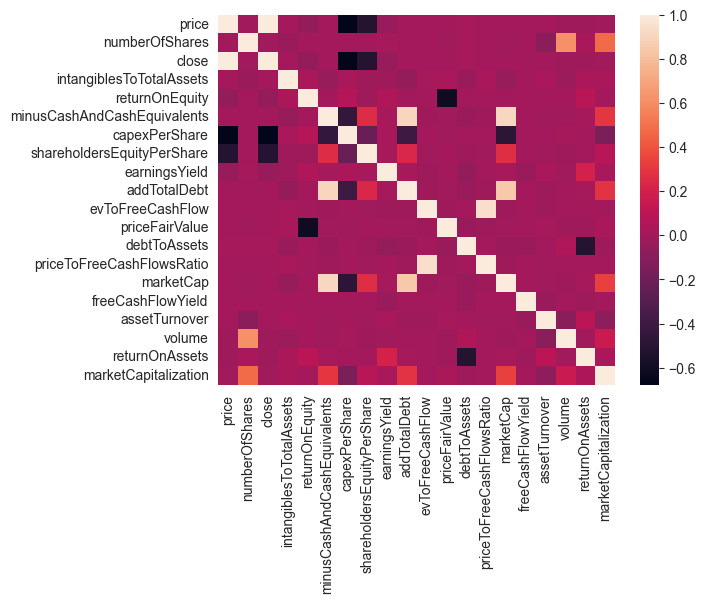

In [51]:
corr_matrix = df.drop(columns=to_drop).select_dtypes(float).corr_matrix()
sns.heatmap(corr_matrix, xticklabels=True, yticklabels=True)

In [56]:
df = df.drop(columns=correlated_columns)

### Impute NaNs

In [60]:
df = df.groupby("symbol").apply(lambda group: group.interpolate().ffill().bfill())

/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_72784/540050061.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby("symbol").apply(lambda group: group.interpolate().ffill().bfill())
/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_72784/540050061.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby("symbol").apply(lambda group: group.interpolate().ffill().bfill())
/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_72784/540050061.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.groupby("symbol").apply(lambda group: group.interpolate().ffill().b

### Final check for NaNs

<Axes: >

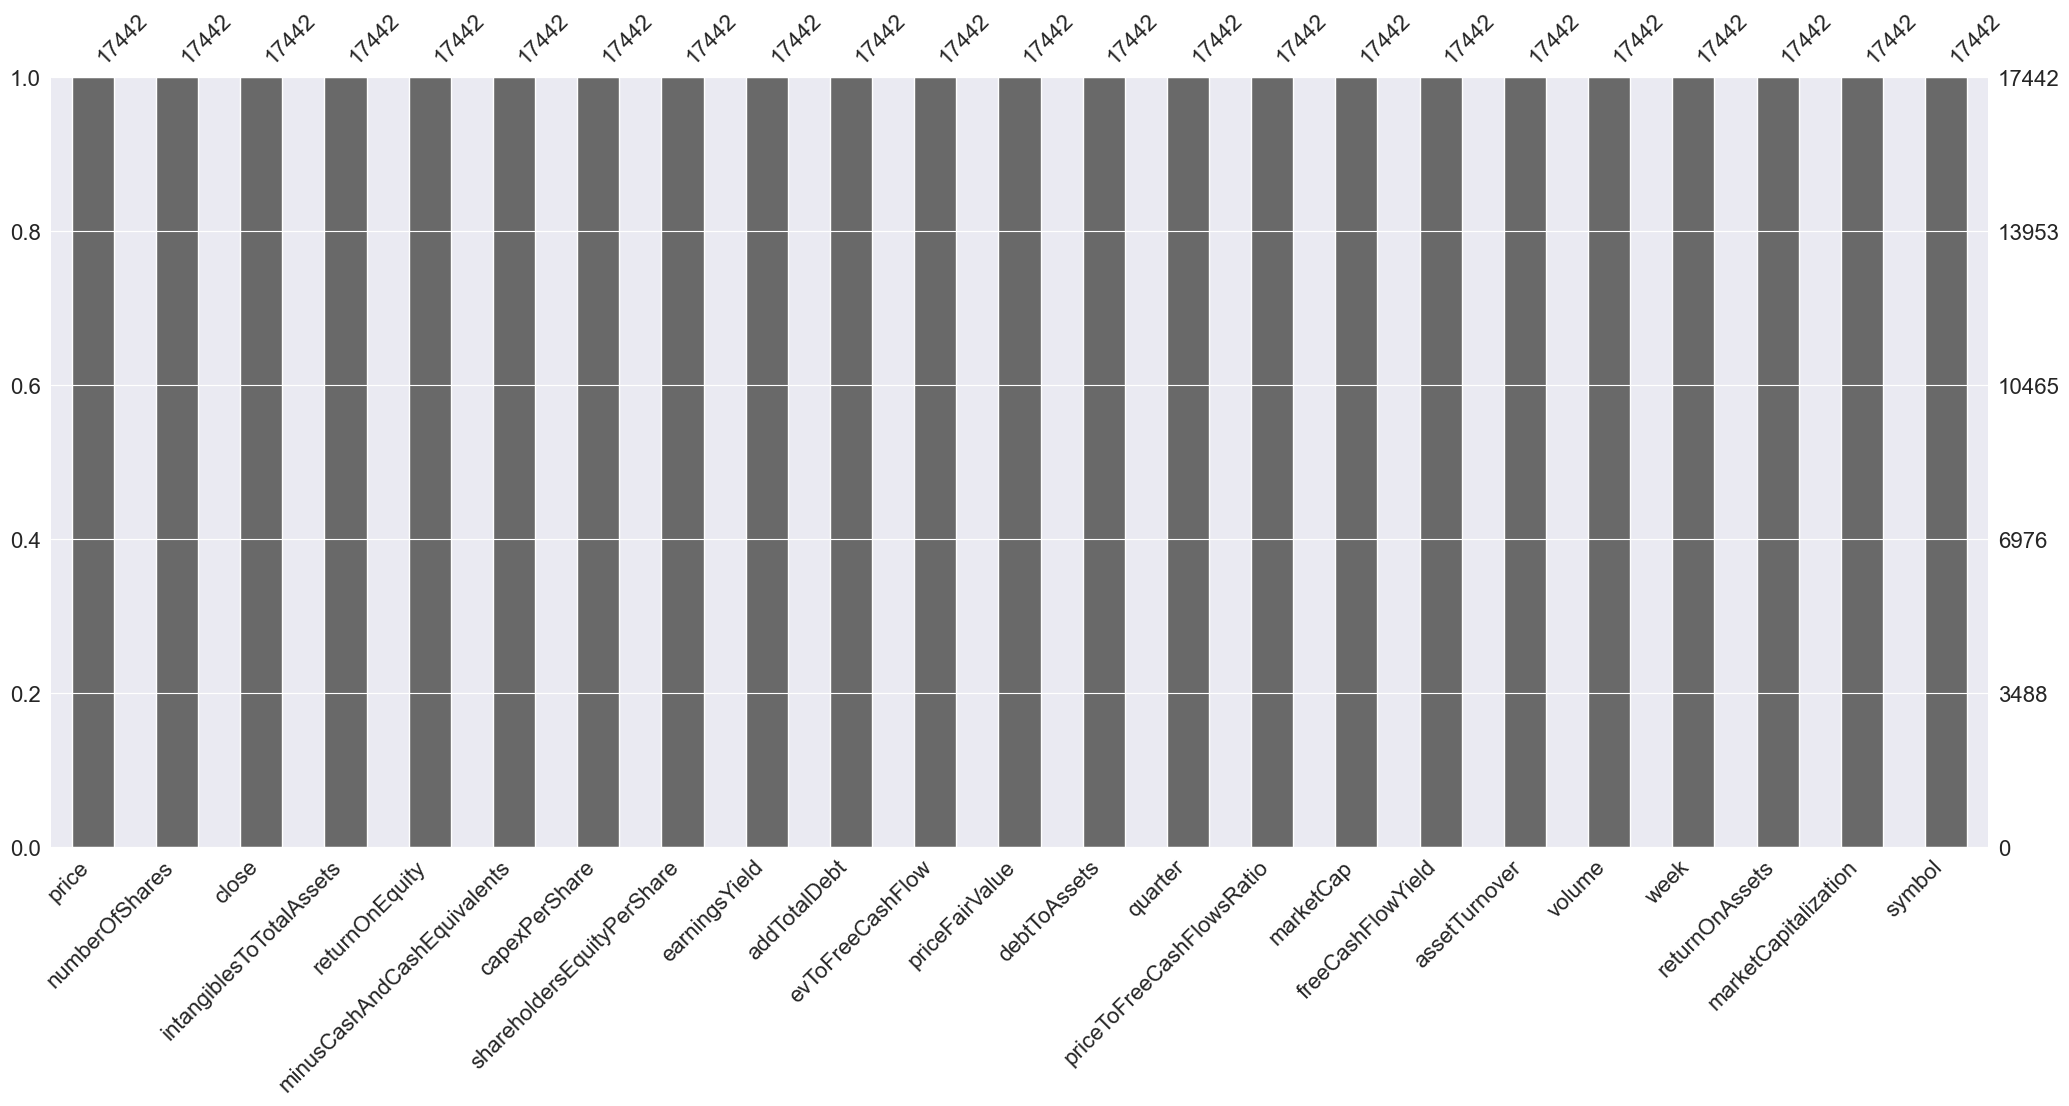

In [62]:
msno.bar(df)

In [63]:
df.to_csv("../data/interim/stocks_drop_n_interpolated.csv")